# Testing ECG transformation with DiffPrivLib

https://github.com/IBM/differential-privacy-library/blob/main/notebooks/pipeline.ipynb

In [1]:
# Generic libraries
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal as sps
from os.path import join as osj
import pickle
import copy
import random

# Differential privacy libraries
from diffprivlib import mechanisms
from diffprivlib import models
from diffprivlib import tools
from diffprivlib.accountant import BudgetAccountant
from diffprivlib.utils import check_random_state
from diffprivlib.mechanisms import Laplace, LaplaceBoundedNoise, LaplaceBoundedDomain
from diffprivlib.mechanisms import DPMechanism

## Global variables

In [20]:
trio = True
minutes = 25 # 5, 25 or 30

In [21]:
if trio:
    DATA_ROOT = osj("..", "dataset_beats_trio")
else:
    DATA_ROOT = osj("..", "dataset_beats")

if minutes == 5:
    BEATS = osj(DATA_ROOT, "5min_normal_beats")
elif minutes == 25:
    BEATS = osj(DATA_ROOT, "25min_beats")
elif minutes == 30:
    BEATS = osj(DATA_ROOT, "30min_beats")

BEATS_READ = osj(BEATS + ".pkl")

## Load data

In [22]:
def read_beats():
    with open(BEATS_READ, "rb") as f:
        return pickle.load(f)

In [23]:
dict_beats = read_beats()

In [24]:
dict_beats[100].keys()

dict_keys(['beats', 'class', 'label'])

In [25]:
df_beats_data = pd.DataFrame.from_dict(dict_beats, orient="index")
df_beats_only = df_beats_data.drop(columns=["class", "label"])
#df_beats_data.head()

In [26]:
df_beats_only.loc[100][0].shape

#  5 Min:  (367, 128)
# 25 Min: (1904, 128)

(1904, 128)

# Calculate sensitivity 

In [27]:
g_min_value = 0
g_max_value = 0

for patient in dict_beats: # patient = 100, 101, 102, ...
    for beat in dict_beats[patient]['beats']: # beat = array[128]
        for value in beat:
            if value < g_min_value:
                g_min_value = value
            if value > g_max_value:
                g_max_value = value

g_sensitivity = g_max_value + abs(g_min_value)
g_sensitivity


1.6568568416396827

Sensitivity is the maximum possible value change if one value is removed from the (normalized) data

In [28]:
print("Min value: ", g_min_value)
print("Max value: ", g_max_value)
print("Sensitivity: ", g_sensitivity)

Min value:  -0.8258956478622729
Max value:  0.8309611937774097
Sensitivity:  1.6568568416396827


# 𝜀, 𝛿 - DP (Laplace)

Generating different Laplace instances:
- s_z = small epsilon and zero  delta
- s_s = small epsilon and small delta
- b_z = big   epsilon and zero  delta
- b_s = big   epsilon and small delta

In [29]:
def set_laplace_mechanism(m, e_p='h', d_p='s', s=g_sensitivity, min=g_min_value, max=g_max_value):
    
    random_state = 42

    if e_p == 's':
        e = 0.01
    elif e_p == 'm':
        e = 1.0
    elif e_p == 'b':
        e = 5.0
    elif e_p == 'h':
        e = 10.0 # DEFAULT
    elif e_p == 'hh':
        e = 20.0 

    if d_p == 'z':
        d = 0.0 # pure Differential Privacy
    elif d_p == 's':
        d = 0.1 # DEFAULT
    elif d_p == 'm':
        d = 0.49 # max for BoundedNoise
    elif d_p == 'b':
        d = 1.0 # max for Laplace
    elif d_p == 'h':
        d = 5.0


    if m == 'laplace':
        laplace = Laplace(epsilon=e, delta=d, sensitivity=s, random_state=random_state)
    elif m == 'bounded_d':
        laplace = LaplaceBoundedDomain(epsilon=e, delta=d, sensitivity=s, lower=min, upper=max, random_state=random_state) # Delta must be in [0, 1].  Cannot be simultaneously zero with epsilon.
    elif m == 'bounded_n':
        laplace = LaplaceBoundedNoise(epsilon=e, delta=d, sensitivity=s, random_state=random_state) # Delta must be > 0 and in (0, 0.5).

    return laplace


## Replace only random values with Laplace value

Iterate over all patients, their beats and ecg values to apply Laplace differential privacy. 
-  5 Min: takes ~15s
- 25 Min: takes ~3m

In [30]:
# create a new dictionary to store the differentially private values
dict_beats_dp = copy.deepcopy(dict_beats)
changed_count = 0
all_count = 0

random.seed(123) # ensures only that the same ecg values are changed, but the results will differ

# iterate over each patient
for patient in dict_beats_dp: # patient = 100, 101, 102, ...
    print("Starting patient: ", patient)
    beats_count = 0 # setting beats to 0 after each patient

    # iterate over each beat
    for beat in dict_beats_dp[patient]['beats']: # beat = array[128]
        value_count = 0 # setting values to 0 after each beat

        max_beat = max(beat)
        min_beat = min(beat)
        sens_beat = max_beat + abs(min_beat)

        laplace = set_laplace_mechanism('bounded_n', 'h', 'm', sens_beat) # laplace, bounded_d, bounded_n
        
        # iterate over each value in the beat
        for value in beat:
            
            # If random bit is 1, add noise to the value
            if random.getrandbits(1) == 1:

                # Add noise to value
                dp_value = laplace.randomise(value)

                # Replace the original value with the randomised value
                dict_beats_dp[patient]['beats'][beats_count][value_count] = dp_value

                #if value_count == 64:
                #     print("Changed rpeak value, e.g. for patient: ", patient, beats_count, value_count, " from ", value, " to ", dp_value)

                changed_count += 1
                # if changed_count == 20:
                #     print("Changed 20 values, e.g. for patient: ", patient, beats_count, value_count, " from ", value, " to ", dp_value)
                # if changed_count == 100:
                #     print("Changed 100 values, e.g. for patient: ", patient, beats_count, value_count, " from ", value, " to ", dp_value)
                # if changed_count == 100000:
                #     print("Changed 100000 values, e.g. for patient: ", patient, beats_count, value_count, " from ", value, " to ", dp_value)
                # if changed_count == 1029259:
                #     print("Changed 1029259 values, e.g. for patient: ", patient, beats_count, value_count, " from ", value, " to ", dp_value)
            
            all_count += 1    
            value_count += 1

        # detrend the beat and normalize it.
        beat = sps.detrend(beat)
        beat = beat / np.linalg.norm(beat, ord=2)
        dict_beats_dp[patient]['beats'][beats_count] = beat
        beats_count += 1

Starting patient:  100
Starting patient:  101
Starting patient:  102
Starting patient:  103
Starting patient:  104
Starting patient:  105
Starting patient:  106
Starting patient:  107
Starting patient:  108
Starting patient:  109
Starting patient:  111
Starting patient:  112
Starting patient:  113
Starting patient:  114
Starting patient:  115
Starting patient:  116
Starting patient:  117
Starting patient:  118
Starting patient:  119
Starting patient:  121
Starting patient:  122
Starting patient:  123
Starting patient:  124
Starting patient:  200
Starting patient:  201
Starting patient:  202
Starting patient:  203
Starting patient:  205
Starting patient:  207
Starting patient:  208
Starting patient:  209
Starting patient:  210
Starting patient:  212
Starting patient:  213
Starting patient:  214
Starting patient:  215
Starting patient:  217
Starting patient:  219
Starting patient:  220
Starting patient:  221
Starting patient:  222
Starting patient:  223
Starting patient:  228
Starting pa

In [31]:
# Proof, that the same values are changed in each run, but the changed value differs
# changed value osf idx 50 and idx 52

# dict_beats[100]['beats'][0][50:55] # original data
# array([ 0.060449  ,  0.04796298,  0.05915449,  0.03368641, -0.00662674])

# dict_beats_dp[100]['beats'][0][50:55] # first run
# array([-0.10919853,  0.04796298, -0.47455325,  0.03368641, -0.00662674])

# dict_beats_dp[100]['beats'][0][50:55] # second run
# array([-0.34065418,  0.04796298, -0.61893132,  0.03368641, -0.00662674])

In [32]:
print(changed_count)
print(all_count)

5456717
10918272


## Visualize data

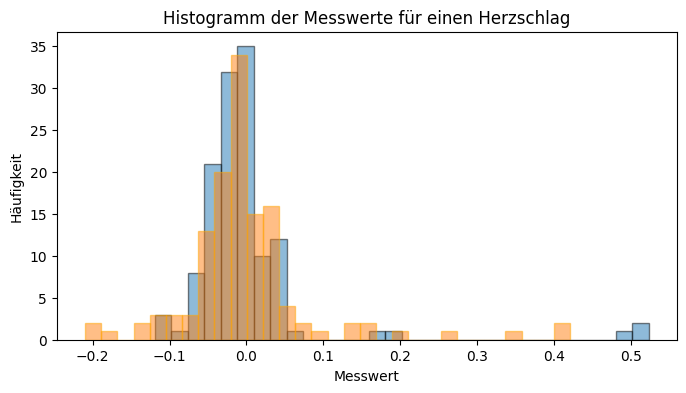

In [33]:
ecg_beat = dict_beats[100]['beats'][29]
ecg_beat_dp = dict_beats_dp[100]['beats'][29]

plt.figure(figsize=(8, 4))
plt.hist(ecg_beat, bins=30, edgecolor='black', alpha=0.5)
plt.hist(ecg_beat_dp, bins=30, edgecolor='orange', alpha=0.5)
plt.xlabel("Messwert")
plt.ylabel("Häufigkeit")
plt.title("Histogramm der Messwerte für einen Herzschlag")
plt.show()

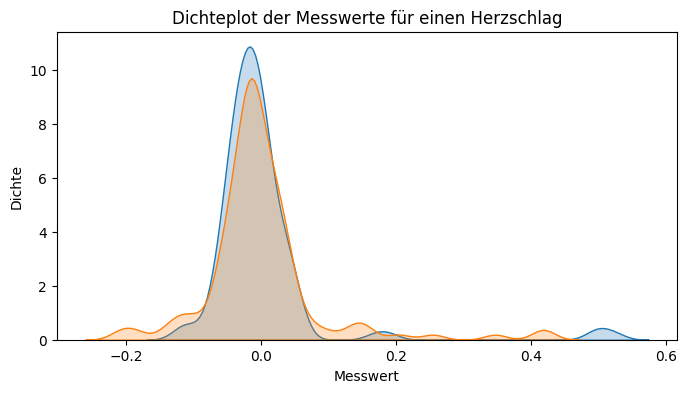

In [34]:
plt.figure(figsize=(8, 4))
sns.kdeplot(ecg_beat, fill=True, bw_adjust=0.5)
sns.kdeplot(ecg_beat_dp, fill=True, bw_adjust=0.5)
plt.xlabel("Messwert")
plt.ylabel("Dichte")
plt.title("Dichteplot der Messwerte für einen Herzschlag")
plt.show()

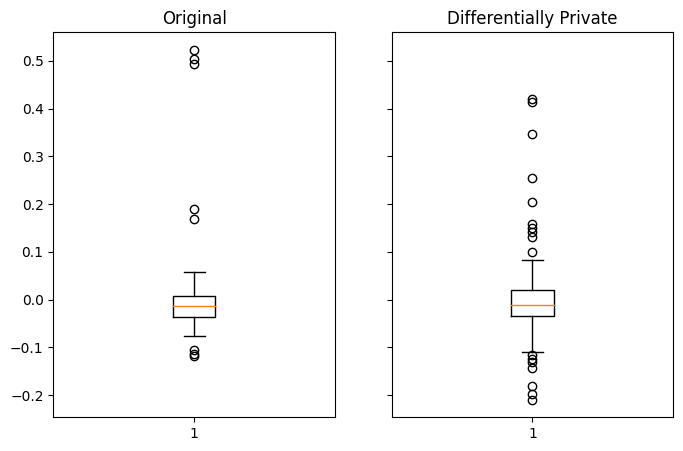

In [35]:

fig, axs = plt.subplots(1, 2, sharey='row', figsize=(8, 5))
axs[0].boxplot(ecg_beat)
axs[0].set_title("Original")
axs[1].boxplot(ecg_beat_dp)
axs[1].set_title("Differentially Private")
plt.show()

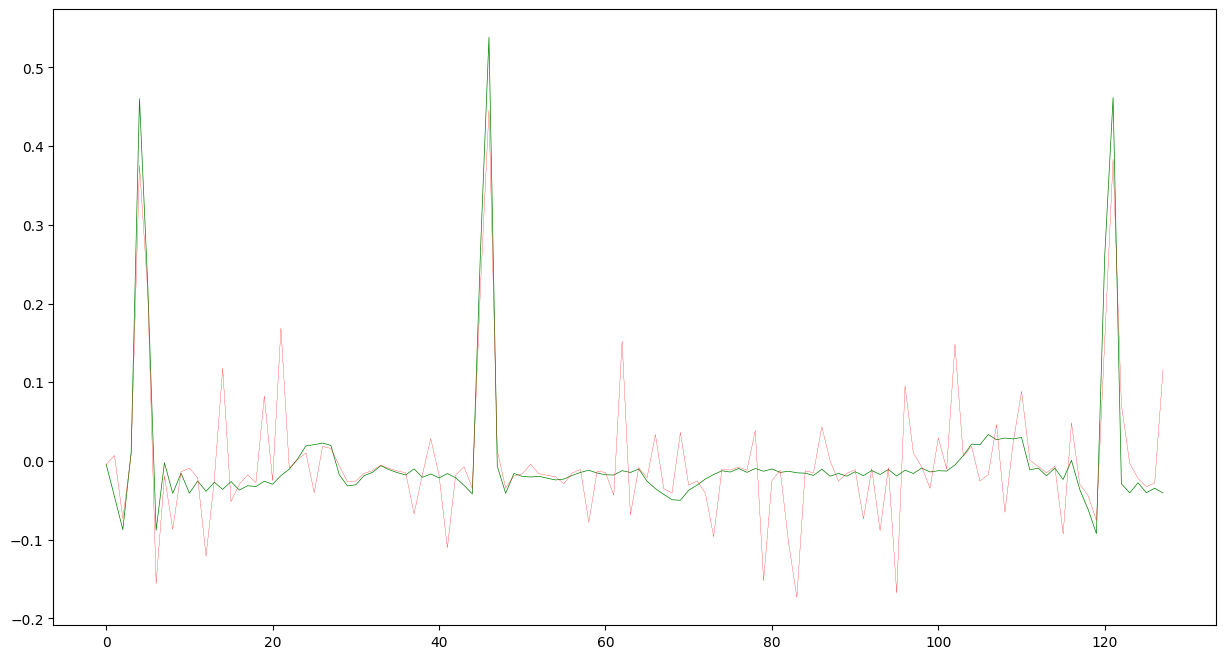

In [36]:
patient_id = 100
#beat_idx = 0:20

plt.figure(figsize=(15, 8), dpi=100)
plt.plot(dict_beats[patient_id]['beats'][1], linewidth=0.5, color='green')
plt.plot(dict_beats_dp[patient_id]['beats'][1], linewidth=0.2, color='red')
#plt.plot(dict_beats[patient_id]['label'][0:20], marker="x", linestyle="", color='green')
#plt.plot(dict_beats_dp[patient_id]['label'][0:20], marker="x", linestyle="", color='red')
plt.show()

## Save data

In [37]:
# save differentially private data

with open(osj(BEATS + "_dp_ln_hm" + ".pkl"), "wb") as f:
        pickle.dump(dict_beats_dp, f)

# 𝜀, 𝛿 DP (Gaussian)

# Testing

## Pipeline without DP - Test

In [ ]:
# # Generic variables
# X_train = []
# y_train = []

# X_test = []
# y_test = []

In [ ]:
# # Pipeline to normalize, reduce dimensionality and classify
# pipe = Pipeline([
#     ('scaler', sk.preprocessing.StandardScaler()),
#     ('pca', sk.decomposition.PCA(2)),
#     ('lr', sk.linear_model.LogisticRegression(solver="lbfgs"))
# ])

In [ ]:
# pipe.fit(X_train, y_train)
# baseline = pipe.score(X_test, y_test)
# print("Non-private test accuracy: %.2f%%" % (baseline * 100))

## Pipeline with DP - Test

In [ ]:
# # DP Imports
# from diffprivlib import mechanisms
# from diffprivlib import models
# from diffprivlib import tools
# from diffprivlib.accountant import BudgetAccountant
# from diffprivlib.utils import check_random_state

# random_state = check_random_state(42)

In [ ]:

# dp_pipe = Pipeline([
#     ('scaler', models.StandardScaler(bounds=([17, 1, 0, 0, 1], [90, 160, 10000, 4356, 99]), random_state=random_state)),
#     ('pca', models.PCA(2, data_norm=5, centered=True, random_state=random_state)),
#     ('lr', models.LogisticRegression(data_norm=5, random_state=random_state))
# ])

In [ ]:
# dp_pipe.fit(X_train, y_train)
# print("Differentially private pipeline accuracy (epsilon=3): %.2f%%" % (dp_pipe.score(X_test, y_test) * 100))

### Cross validation epsilon

In [ ]:
# epsilons = np.logspace(-3, 0, 500)
# pipe_accuracy = []

# for epsilon in epsilons:
#     _eps = epsilon / 3
#     dp_pipe.set_params(scaler__epsilon=_eps, pca__epsilon=_eps, lr__epsilon=_eps)
    
#     dp_pipe.fit(X_train, y_train)
#     pipe_accuracy.append(dp_pipe.score(X_test, y_test))

In [ ]:
# import pickle

# pickle.dump((epsilons, baseline, pipe_accuracy), open("pipeline_accuracy_500.p", "wb" ) )

In [ ]:
# # plot results
# import matplotlib.pyplot as plt
# import pickle

# epsilons, baseline, pipe_accuracy = pickle.load(open("pipeline_accuracy_500.p", "rb"))

# plt.semilogx(epsilons, pipe_accuracy, label="Differentially private pipeline", zorder=10)
# plt.plot(epsilons, np.ones_like(epsilons) * baseline, dashes=[2,2], label="Non-private pipeline", zorder=5)
# plt.title("Differentially private pipeline accuracy")
# plt.xlabel("epsilon")
# plt.ylabel("Accuracy")
# plt.ylim(0, 1)
# plt.xlim(epsilons[0], epsilons[-1])
# plt.legend(loc=4)
# plt.show()

## Laplace - Test

In [129]:
# data = 5.9
# epsilon = 0.6
# delta = 0.8
# sensitivity = 1.0
# random_state = 42

# laplace = Laplace(epsilon=epsilon, delta=delta, sensitivity=sensitivity, random_state=random_state)


In [92]:
# laplace.randomise(data)

/home/rbeck1_sw/miniconda3/envs/diffprivlib/lib/python3.12/site-packages/diffprivlib/mechanisms/laplace.py:145: RuntimeWarning: divide by zero encountered in log
  scale = self.sensitivity / (self.epsilon - np.log(1 - self.delta))


np.float64(5.9)

In [96]:
# array_data = np.array([1.2, -0.992, 2.131, 3.333, 0.2131])
# i = 0

# for d in array_data:
#     random_d = laplace.randomise(d)
#     array_data[i] = random_d
#     i += 1

In [97]:
# array_data

array([ 0.8083757 , -0.94898813,  1.86866599,  4.04438062,  0.35644367])

In [90]:
# array_data

array([ 1.39006409, -2.15122141,  5.27450263,  3.96641788,  2.20865526])

In [97]:
# number = []

# for i in range(20):
#     number.append(random.getrandbits(1))

# number

[0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1]